---
### Author: Marcin Płodzień 
### Email: marcin.plodzien@icfo.eu
### Affiliation: ICFO - Institute of Photonic Sciences
---

# One-dimensional XXZ Heisenberg model with Transverse Field: A Tutorial
In this tutorial, we will consider the phase diagram of the **quantum XXZ Heisenberg model** in the presence of a **transverse field**. Next, we will use dimensionality reduction techniques, namely PCA and t-SNE, to investigate distinct quantum phases in the model.

### Model Hamiltonian

The general one-dimensional quantum Heisenberg Hamiltonian with transverse field (open boundary conditions) is given by:
\begin{equation}
H = - \sum_{i=1}^{L-1} \left( J_x\hat{\sigma}^x_i \hat{\sigma}^x_{i+1} + J_y\hat{\sigma}^y_i \hat{\sigma}^y_{i+1} + \Delta \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} \right) 
    - h_z \sum_{i=1}^L \hat{\sigma}^z_i
\end{equation}
where:
- $\hat{\sigma}^{x,y,z}_i$ are spin operators at site $i$ in a spin-$1/2$ chain,
- $\Delta$ is the anisotropy parameter,
- $h_z$ is the transverse field in the $z$-direction.

When $J_x = J_y = J_z$ we deal with $XXX$ Hamiltonian, while when $J_y = \Delta = 0$, and $J_x\ne0$ we have quantum Ising model in a transvevrse field. The XXZ model (without transverse field) is exactly solvable by Bethe ansatz.

These models a cornerstone in quantum many-body physics, providing insights into quantum entanglement and spin interactions, see
1. Great textbook: [Quantum Physics in One Dimension](https://academic.oup.com/book/27811) by Thierry Giamarchi.
2. Great textbook: [An Introduction to Integrable Techniques for One-Dimensional Quantum Systems](https://link.springer.com/book/10.1007/978-3-319-48487-7) by Fabio Franchini.
3. Introduction to exactly solvable spin-$1/2$ models: [A pedagogical introduction to quantum integrability, with a view towards theoretical high-energy physics](https://pos.sissa.it/232/001)

These models are topic of many research studies, focusing on their realization on quantum hardwared, as examples you can see:
1. [Preparing ground states of the XXZ model using the quantum annealing with inductively coupled superconducting flux qubits](https://arxiv.org/pdf/2112.12419)
2. [Exact Ising model simulation on a quantum computer](https://quantum-journal.org/papers/q-2018-12-21-114/)


To study numerically the model allowing extracting its thermodynamics limit (i.e. infinite system size) properties it is necessarry to consider large number of spins $L\gg 1$. The state-of-the-art numerical methods are based on tensor networks, Matrix Product States, and DMRG calculations. Here, we will work with small system sizes $L \le 10$, and we will construct exact matrix representation of the Hamiltonian, diagonalize it, calculate ground state and its properties.

### XXZ model
In this tutorial we will study, withing the Exact Diagonalization approach, the XXZ model ($J_x = J_y = 1 \ne \Delta$) in a transverse field
$h_z \ge 0$:
\begin{equation}
H = - \sum_{i=1}^{L-1} \left( \hat{\sigma}^x_i \hat{\sigma}^x_{i+1} + \hat{\sigma}^y_i \hat{\sigma}^y_{i+1} + \Delta \hat{\sigma}^z_i \hat{\sigma}^z_{i+1} \right) 
    - h_z \sum_{i=1}^L \hat{\sigma}^z_i
\end{equation}

In particular, we will

1. Construct the Hamiltonian for $L$ spins.
2. Perform exact diagonalization to find the ground state and compute observables.
3. Calculate entanglement entropy and analyze system properties.
4. Visualize the results.


The goal is to analyze ground state properties of the model for small system size $L$.

We need to start with definitions of many-body operators acting on $L$ spins-$1/2$ chain.


In [11]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.linalg import eigh, cholesky
import itertools
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from functools import reduce


# Define Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
identity = np.eye(2, dtype=complex)


### Function Definitions
The following functions are used throughout this notebook:
1. **Fock Basis Generation:** `generate_fock_basis` generates all possible spin configurations.
2. **Operators Construction:** `construct_operator` and `total_spin_operator` build spin operators for the system.

In [2]:
def generate_fock_basis(L):
    """
    Generate the Fock basis for L spins.

    Parameters:
        L (int): Number of spins.

    Returns:
        tuple: A tuple containing:
            - list of tuples: List where each tuple is a basis vector.
            - dict: Dictionary with spin vectors as keys and their indices as values.
    """
    # Total number of basis states is 2**L
    num_states = 2 ** L

    # Generate all basis vectors as binary representations of integers
    basis = []
    index_map = {}
    for i in range(num_states):
        binary_representation = format(i, f"0{L}b")  # Binary string with L bits
        spin_vector = tuple(1 - 2 * int(bit) for bit in binary_representation)  # Map 0 -> +1 (up), 1 -> -1 (down)
        basis.append(spin_vector)
        index_map[spin_vector] = i

    return basis, index_map

def construct_sigma_operator(sigma, L, site):
    """
    Constructs an operator acting on a specific site in an L-spin system.

    Args:
        pauli (np.ndarray): Pauli matrix for the operator.
        L (int): Number of spins.
        site (int): Site index (0-based) where the operator acts.

    Returns:
        np.ndarray: Operator acting on the full L-spin system.
    """
    operators = [identity if i != site else sigma for i in range(L)]
    return reduce(np.kron, operators)

def total_sigma_operator(L, sigma):
    """
    Construct the total spin operator for a specific component.

    Args:
        L (int): Number of spins.
        pauli (np.ndarray): Pauli matrix for the spin component (x, y, or z).

    Returns:
        np.ndarray: Total spin operator matrix.
    """
    return sum(construct_sigma_operator(sigma, L, i) for i in range(L))



### Function Definitions

The following functions are used throughout this notebook:
1. **Hamiltonian Construction:** `xxz_hamiltonian` constructs the XXZ model Hamiltonian.
2. **Exact Diagonalization:** `exact_ground_state` finds the ground state of the Hamiltonian.
3. **Entanglement Entropy:** Functions to compute partial traces and von Neumann entropy.


In [3]:
def xxz_hamiltonian(L, delta, hz):
    """
    Construct the XXZ Hamiltonian for L spins with anisotropy delta.

    Args:
        L (int): Number of spins.
        delta (float): Anisotropy parameter.
        h (float): transverse field

    Returns:
        np.ndarray: The XXZ Hamiltonian matrix.
    """
    H = np.zeros((2**L, 2**L), dtype=complex)
    for i in range(L-1):

        j = i+1
 
        sigma_x_i = construct_sigma_operator(sigma_x, L, i)
        sigma_x_j = construct_sigma_operator(sigma_x, L, j)
        
        sigma_y_i = construct_sigma_operator(sigma_y, L, i)
        sigma_y_j = construct_sigma_operator(sigma_y, L, j)
        
        sigma_z_i = construct_sigma_operator(sigma_z, L, i)
        sigma_z_j = construct_sigma_operator(sigma_z, L, j)
      
        H += -( np.dot(sigma_x_i, sigma_x_j) + np.dot(sigma_y_i, sigma_y_j) + delta * np.dot(sigma_z_i, sigma_z_j) ) 
    
    for i in range(L):
        sigma_z_i = construct_sigma_operator(sigma_z, L, i)
        H += -hz*sigma_z_i
        
    return H
 
def exact_ground_state(H):
    """
    Compute the ground state of a Hamiltonian via exact diagonalization.

    Args:
        H (np.ndarray): Hamiltonian matrix.

    Returns:
        tuple: Ground state wavefunction and its energy.
    """
    eigenvalues, eigenvectors = eigh(H)
    psi_0 = eigenvectors[:, 0]  
    return psi_0,  eigenvalues[0:5]

def density_matrix(psi):
    """
    Construct the density matrix for a given state.

    Args:
        psi (np.ndarray): Wavefunction.

    Returns:
        np.ndarray: Density matrix.
    """
    return np.outer(psi, psi.conj())


def cholesky_matrix_to_cholesky_vector(A):
    """
    Extract the non-zero elements of the lower triangular part of a Cholesky matrix A 
    (including the diagonal) into a vector.

    Args:
        A (np.ndarray): Cholesky matrix (assumed to be square and possibly complex).

    Returns:
        np.ndarray: Vector containing non-zero elements of the lower triangular part.
    """
    if not isinstance(A, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    if A.shape[0] != A.shape[1]:
        raise ValueError("Input matrix must be square.")
    
    # Extract the lower triangular part
    A_LT = np.tril(A)
    
    # Select non-zero elements only
    non_zero_indices = np.tril_indices(A.shape[0])
    L_real = np.real(A_LT[non_zero_indices])
    L_imag = np.imag(A_LT[non_zero_indices])
    
    # Concatenate real and imaginary parts
    return np.concatenate([L_real, L_imag])

def cholesky_vector_to_cholesky_matrix(vector):
    """
    Reconstruct a Cholesky matrix from a vector containing non-zero elements 
    of its lower triangular part (including diagonal).

    Args:
        vector (np.ndarray): Flattened vector containing real and imaginary parts of non-zero elements.

    Returns:
        np.ndarray: Reconstructed Cholesky matrix, potentially complex.
    """
    # Determine the total number of elements in the lower triangular part
    num_elements = len(vector) // 2  # Each element has real and imaginary parts

    # Solve for n using the quadratic formula
    n = int((-1 + np.sqrt(1 + 8 * num_elements)) / 2)
    
    if n * (n + 1) // 2 != num_elements:
        raise ValueError("Invalid vector length: cannot correspond to a lower triangular matrix.")

    # Split the vector into real and imaginary parts
    half_length = len(vector) // 2
    L_real = vector[:half_length]
    L_imag = vector[half_length:]
    
    # Combine into a complex array if imaginary part exists
    L = L_real + 1j * L_imag

    # Initialize an empty matrix
    A = np.zeros((n, n), dtype=complex)

    # Fill in the lower triangular part
    tril_indices = np.tril_indices(n)
    A[tril_indices] = L

    return A

def get_SvN(psi):
    """ Calculate reduced density matrix rho_A = Tr_B[rho_AB]
        and its von Neuman entanglement entropy S_vN = -Tr[rho_A log[rho_A]]
    """
    rho_A = np.zeros((2**L_A, 2**L_A), dtype = np.complex128)
    for ket_v_A in fock_basis_A:
        idx_v_A = index_map_A[ket_v_A]
        for ket_w_A in fock_basis_A:
            idx_w_A = index_map_A[ket_w_A]
            for ket_v_B in fock_basis_B:
                ket_v_A_v_B = ket_v_A + ket_v_B
                ket_w_A_v_B = ket_w_A + ket_v_B
                
                idx_1 = index_map_AB[ket_v_A_v_B]
                idx_2 = index_map_AB[ket_w_A_v_B]
                
                rho_A[idx_v_A, idx_w_A] += np.conj(psi[idx_1])*psi[idx_2]
                
    lambdas = np.linalg.eigvalsh(rho_A)
    SvN = 0
    epsilon = 1e-10
    for lambda_ in lambdas:
        SvN = SvN - lambda_*np.log(lambda_ + epsilon)
    return rho_A, SvN


### Main Simulation

Now, we will we compute the ground state, and calulcate expectation values for the XXZ model for fixed system size $L$ for various values of:
- Anisotropy parameter $\Delta$
- Transverse field $h_z$

We will collect:
1. Ground state $|\psi_{gs}\rangle$
2. Eigenenergies of first $5$ eigenstates.
3. Expectation values of total spin operators $\hat{S}^{x,y,z}$ and their standard deviations.
4. von Neuman entanglement entropy of after partial trace of half of spins $S_{\rm vN} = -Tr_B(\hat{\rho}_{gs}\log\hat{\rho}_{gs})$, where
   $\hat{\rho}_{gs} = |\psi_{gs}\rangle\langle\psi_{gs}|$

We will use one trick: instead of storing the whole state $|\psi_{gs}\rangle$ we will store Cholesky decomposition of its density matrix $\hat{\rho}_{gs}$.

In general the Cholesky decomposition of a Hermitian matrix $\hat{\rho}$ reads
\begin{equation}
\hat{\rho} = AA^\dagger,
\end{equation}
where $A$ is lower-triangular matrix. Now, we can vectorize Cholesky matrix $A$, i.e. store its only lower-triangular elements as $A_{\rm vec} = [Re[A], Im[A]]$. Of course, having Cholesky vector we can restore original denisty matrix, see example:


In [4]:
# Check if mapping: rho -> cholesky_matrix -> cholesky_vector
# is consistent with: cholesky_vector -> cholesky_matrix -> rho
L = 4
dim = 2**L
psi = np.random.rand((2**L)) + 0*1j
psi = psi/np.sqrt(np.sum(np.abs(psi)**2))

rho = np.outer(psi.conj(), psi)
epsilon = 1e-6
rho = (1-epsilon)*rho + epsilon*np.eye(dim)/dim

A = cholesky(rho, lower=True)
A_vec = cholesky_matrix_to_cholesky_vector(A)
A_ = cholesky_vector_to_cholesky_matrix(A_vec)
rho_ = A_@A_.conj().T/np.trace(A_@A_.conj().T)            
print("Check if Cholesky decomposition and vectorization is consistent: ", np.allclose(rho, rho_))

Check if Cholesky decomposition and vectorization is consistent:  True


### Cholesky Decomposition in practice

Cholesky decomposition is a matrix factorization method used for symmetric and positive-definite matrices, i.e. for a given  Hermitian (or symmetric) positive-definite matrix $\rho$, we can find its representation in the form:
\begin{equation}
\rho = \frac{A A^\dagger}{Tr[A A^\dagger]},
\end{equation}
where $A$ is a lower triangular matrix with real and positive diagonal entries.

The Cholesky decomposition of a matrix $\rho$ is computed element by element. For $\rho = A A^\dagger$, where $A$ is a lower triangular matrix, the entries of $A$ are calculated as:
1. For diagonal elements:
    $A_{ii} = \sqrt{\rho_{ii} - \sum_{k=1}^{i-1} A_{ik}^2}$
2. For off-diagonal elements:
    $A_{ij} = \frac{1}{A_{jj}} \left(\rho_{ij} - \sum_{k=1}^{j-1} A_{ik} A_{jk}\right)$
    for $i > j$.


Cholesky decomposition requires that $\rho$ must be positive-definite, i.e. all eigenvalues of $\rho$ are greater than zero.
If these conditions are not satisfied, the Cholesky decomposition does not exist.
When $\rho$ is nearly positive-definite (e.g., due to numerical precision errors), Cholesky decomposition can fail. In such cases, regularization techniques is needed, by adding a small multiple of the identity matrix to $\rho$, i.e. $\rho' = (1-\epsilon)\rho + \frac{\epsilon}{dim(\rho)} \mathbb{1}$, where $\epsilon$ is a small positive number, and $\mathbb{1}$ is diagonal matrix. This adjustment ensures $\rho'$ is positive-definite and allows Cholesky decomposition to proceed.
For $\epsilon \approx 10^{-6}$ the regularization only slightly alters $\rho$ but ensures numerical stability. Cholesky decomposition is widely used in analysis of  density matices in quantum mechanics.

### Main loop
In the following, we will calculate and store in pandas dataframe all quantities of interest. We will loop over $\Delta \in [-2,2]$ and $h_z \in [0,3]$ for fixed $L$, and store the dataframe to file

In [72]:
L_values = [8]
delta_values = np.arange(-2, 2, 0.05)
hz_values = np.arange(0, 3, 0.05)

for L in L_values:
    data = []
    dim = 2**L
    
    L_A = L//2
    L_B = L - L_A
    fock_basis_AB, index_map_AB = generate_fock_basis(L)
    fock_basis_A, index_map_A  = generate_fock_basis(L_A)
    fock_basis_B, index_map_B = generate_fock_basis(L_B)
    
    
    Sx_total = total_sigma_operator(L, sigma_x)/2.0 #we divide by 2 to have proper spin-chain operators
    Sy_total = total_sigma_operator(L, sigma_y)/2.0 #we divide by 2 to have proper spin-chain operators
    Sz_total = total_sigma_operator(L, sigma_z)/2.0 #we divide by 2 to have proper spin-chain operators
   
    
    for delta in tqdm(delta_values):
        for hz in hz_values:
            if(delta !=0 and hz !=0): 
                H = xxz_hamiltonian(L, delta, hz)
                psi_gs, E_vec = exact_ground_state(H)
                _, SvN = get_SvN(psi_gs)
                rho_gs = density_matrix(psi_gs)
                epsilon = 1e-6
                rho_gs = (1-epsilon)*rho_gs + epsilon*np.eye(dim)/dim
        
                A_gs = cholesky(rho_gs, lower=True)
                A_gs_vec = cholesky_matrix_to_cholesky_vector(A_gs)
        
                # Check if mapping: rho -> cholesky_matrix -> cholesky_vector
                # is consistent with: cholesky_vector -> cholesky_matrix -> rho
                # A_gs_ = cholesky_vector_to_cholesky_matrix(A_gs_vec)
                # rho_gs_ = A_gs_@A_gs_.conj().T/np.trace(A_gs_@A_gs_.conj().T)            
                # print(np.allclose(rho_gs, rho_gs_))
                
                # Compute expectation values of total spin operators
                Sx = np.real(np.vdot(psi_gs, Sx_total @ psi_gs))
                Sy = np.real(np.vdot(psi_gs, Sy_total @ psi_gs))
                Sz = np.real(np.vdot(psi_gs, Sz_total @ psi_gs))
    
                SxSx = np.real(np.vdot(psi_gs, Sx_total@Sx_total @ psi_gs))
                SySy = np.real(np.vdot(psi_gs, Sy_total@Sy_total @ psi_gs))
                SzSz = np.real(np.vdot(psi_gs, Sz_total@Sz_total @ psi_gs))
                
                Sx_std = np.sqrt(SxSx - Sx**2)
                Sy_std = np.sqrt(SySy - Sy**2)
                Sz_std = np.sqrt(SzSz - Sz**2)   
    
                #monitor_string = "L = {:d} | delta = {:2.2f} | h_z = {:2.2f} | E_0 = {:2.2f} | <Sx> = {:2.2f} | <Sy> = {:2.2f} | <Sz> = {:2.2f} | SvN = {:2.2f}".format(L, delta, hz, E_vec[0], Sx, Sy, Sz, SvN)
                #print(monitor_string)
                data.append({
                    "L"         : L,
                    "delta"     : delta,
                    "hz"        : hz, 
                    "SvN"       : SvN,
                    "E_0"       : E_vec[0],
                    "E_1"       : E_vec[1],
                    "E_2"       : E_vec[2],
                    "E_3"       : E_vec[3],
                    "E_4"       : E_vec[4],
                    "Sx"        : Sx,
                    "Sy"        : Sy,
                    "Sz"        : Sz,
                    "Sx_std"    : Sx_std,
                    "Sy_std"    : Sx_std,
                    "Sz_std"    : Sx_std,
                    "A_gs_vec"  : A_gs_vec,
                })
    df_all = pd.DataFrame(data)   
    df_all.to_pickle("./data_XXZ_ground_state_properties_L." + "{:02d}".format(L) + ".pkl")

  0%|                                                    | 0/80 [00:00<?, ?it/s]/tmp/ipykernel_150297/1257775031.py:51: RuntimeWarning: invalid value encountered in sqrt
  Sz_std = np.sqrt(SzSz - Sz**2)
100%|███████████████████████████████████████████| 80/80 [04:51<00:00,  3.64s/it]


With pandas dataframes we can eaisily access informations for different parameters, eg

In [78]:
hz = 0.1
delta = 0
cond_hz = np.abs(df_all["hz"]-hz)<1e-6
cond_delta = np.abs(df_all["delta"]-delta)<1e-6

df_ = df_all[cond_hz & cond_delta]

E_0 = df_['E_0'].values[0]
Sx  = df_['Sx'].values[0]
Sy  = df_['Sy'].values[0]
Sz  = df_['Sz'].values[0]
SvN = df_['SvN'].values[0]

Sx_std  = df_['Sx_std'].values[0]
Sy_std  = df_['Sy_std'].values[0]
Sz_std  = df_['Sz_std'].values[0]

monitor_string_1 = "L = {:d} | delta = {:2.2f} | h_z = {:2.2f}".format(L, delta, hz)
monitor_string_2 = "      E_0 = {:2.2f} | SvN = {:2.2f}".format(E_0, SvN)
monitor_string_3 = "     <Sx> = {:2.2f}  | <Sy>     = {:2.2f}  |     <Sz> = {:2.2f} ".format(Sx, Sy, Sz)
monitor_string_4 = " <Sx_std> = {:2.2f}  | <Sy_std> = {:2.2f}  | <Sz_std> = {:2.2f} ".format(Sx_std, Sy_std, Sz_std)
print(monitor_string_1)
print(monitor_string_2)
print(monitor_string_3)
print(monitor_string_4)

L = 8 | delta = 0.00 | h_z = 0.10
      E_0 = -9.52 | SvN = 0.57
     <Sx> = 0.00  | <Sy>     = 0.00  |     <Sz> = 0.00 
 <Sx_std> = 2.77  | <Sy_std> = 2.77  | <Sz_std> = 2.77 


### Phases of the model

Let us have a look at properties of the system as a function of $\Delta$ and $h_z$. The easiest step will be to look at density plots. We will plot phase diagram for:

1. Ground state energy $E_0$
2. von Neuman entanglement entropy $S_{\rm vN}$
3. Expectation value $\langle\hat{S}_x\rangle$ and its standard deviation $\langle\Delta \hat{S}_x\rangle = \sqrt{\langle\hat{S}_x\hat{S}_x\rangle - \langle\hat{S}_x\rangle^2}$
4. Expectation value $\langle\hat{S}_z\rangle$ and its standard deviation $\langle\Delta \hat{S}_z\rangle =\sqrt{\langle\hat{S}_z\hat{S}_z\rangle - \langle\hat{S}_z\rangle^2}$ 

In [83]:
# Set global font sizes
plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 16,   # Title font size
    'axes.labelsize': 14,   # X and Y labels font size
    'xtick.labelsize': 14,  # X-axis tick font size
    'ytick.labelsize': 14,  # Y-axis tick font size
    'legend.fontsize': 14,  # Legend font size
    'figure.titlesize': 18  # Figure title font size
})
cmap_string = 'plasma'

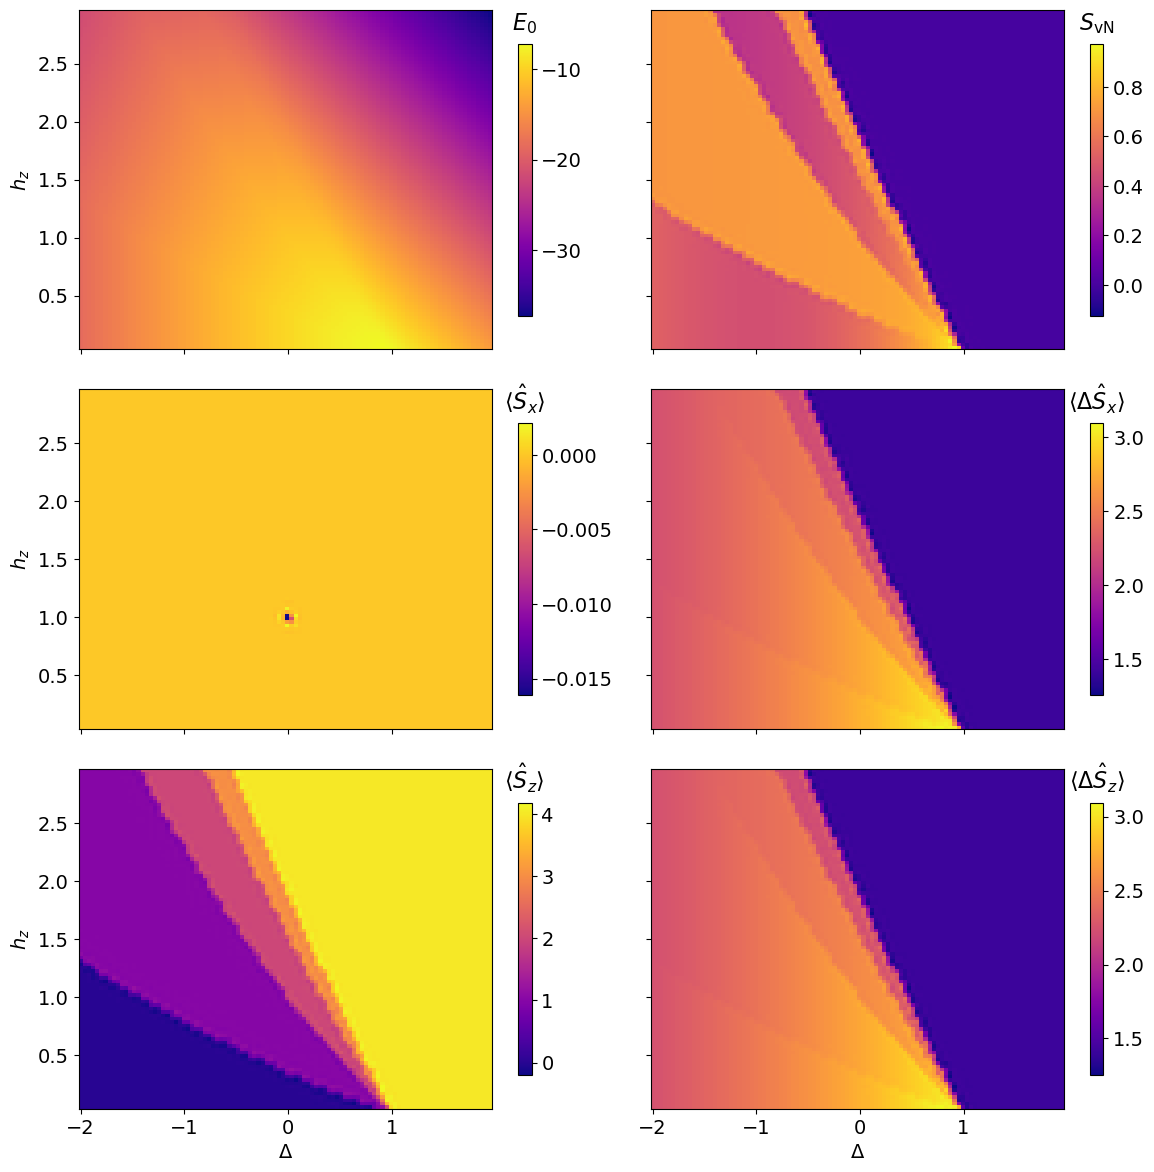

In [84]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey = True, sharex = True)

############
observable = 'E_0'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')

im1 = axes[0, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar1 = fig.colorbar(im1, ax=axes[0, 0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(r"$E_0$", pad=10)  # Label on top of the colorbar
 
 
############
observable = 'SvN'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im3 = axes[0,1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=axes[0,1], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(r"$S_{\rm vN}$", pad=10)  # Label on top of the colorbar

############
observable = 'Sx'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\hat{S}_x\rangle$", pad=10)  # Label on top of the colorbar

############
observable = 'Sx_std'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[1, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[1, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\Delta\hat{S}_x\rangle$", pad=10)  # Label on top of the colorbar
 
############
observable = 'Sz'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 0].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 0], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar

############
observable = 'Sz_std'
x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)
Z = griddata((x, y), z, (X, Y), method='cubic')
im2 = axes[2, 1].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar2 = fig.colorbar(im2, ax=axes[2, 1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(r"$\langle\Delta\hat{S}_z\rangle$", pad=10)  # Label on top of the colorbar
 

axes[2,0].set_xlabel(r'$\Delta$')
axes[2,1].set_xlabel(r'$\Delta$')

axes[0,0].set_ylabel(r'$h_z$')
axes[1,0].set_ylabel(r'$h_z$')
axes[2,0].set_ylabel(r'$h_z$')

# Adjust layout
plt.tight_layout()
plt.show()

As we can see, the density plot of $\langle\hat{S}_z\rangle$ or $S_{\rm vN}$ clearly show existence of distinct phases in the model, characterized by different entanglement properties.

### Unsupervised analysis

Let us performe unsupervised analysis of the ground state properties. We will check if Cholesky vectors $A_{vec}$ are indeed grouped in distinct clusters. We will perform PCA and t-SNE dimensionality reduction, projecting each Cholesky vector onto two-dimensional plane.

#### PCA and t-SNE on Cholesky vectors

In [85]:
all_vectors = np.stack(df_all['A_gs_vec'].values)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_vectors)

# Add PCA results to DataFrame
df_all['PCA1'] = reduced_data[:, 0]
df_all['PCA2'] = reduced_data[:, 1]

In [86]:
all_vectors = np.stack(df_all['A_gs_vec'].values)
perplexity = 50
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
tsne_data = tsne.fit_transform(all_vectors)

# Add t-SNE results to DataFrame
df_all['tSNE1'] = tsne_data[:, 0]
df_all['tSNE2'] = tsne_data[:, 1]

Let's have a look at dimensionality reduction results, using coloring 

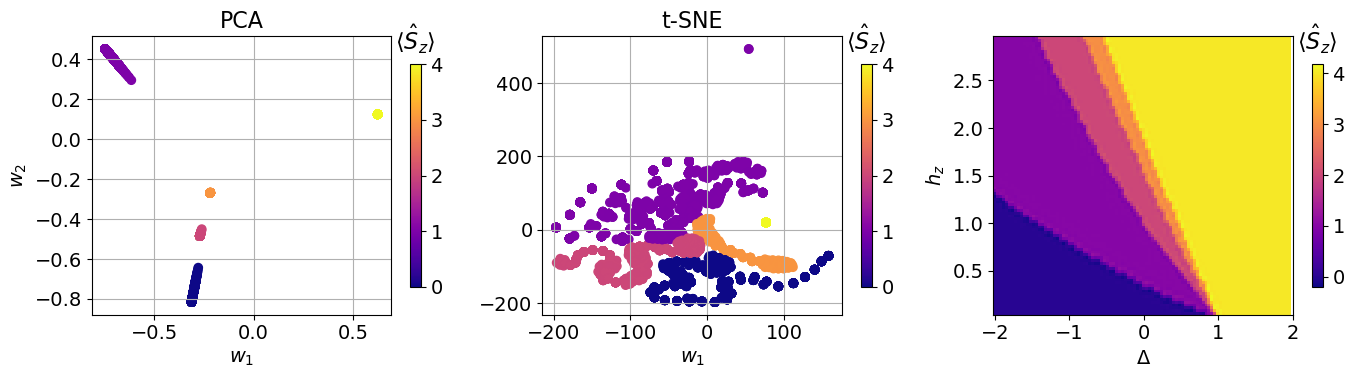

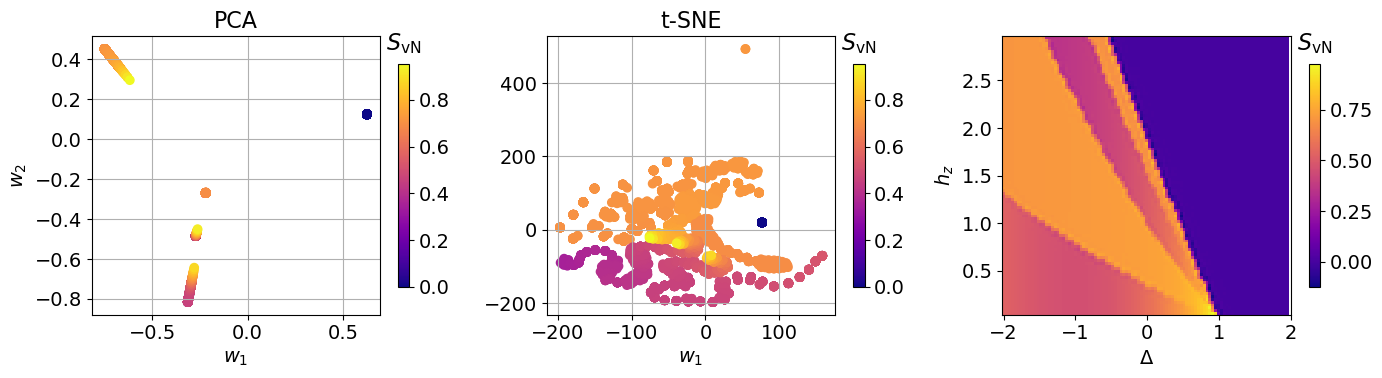

In [87]:
observable = 'Sz'  

if(observable == 'Sz'):
    title_string = r"$\langle\hat{S}_z\rangle$"

if(observable == 'Sx'):
    title_string = r"$\langle\hat{S}_x\rangle$"

if(observable == 'Sx_std'):
    title_string = r"$\langle\Delta\hat{S}_x\rangle$"

if(observable == 'Sz_std'):
    title_string = r"$\langle\Delta\hat{S}_z\rangle$"

if(observable == 'SvN'):
    title_string = r"$S_{\rm vN}$"    

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Subplot 1: PCA scatter plot
sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(title_string, pad=10)  # Label on top of the colorbar

axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_2$')
axes[0].set_title('PCA')
axes[0].grid(True)

# Subplot 2: t-SNE scatter plot
sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(title_string, pad=10)  # Label on top of the colorbar



axes[1].set_xlabel(r'$w_1$')
# axes[1].set_ylabel(r'$w_2$')
axes[1].set_title('t-SNE')
axes[1].grid(True)

# Subplot 3: Colormap

x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]

# Create a structured grid
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)

# Interpolate z values onto the grid
Z = griddata((x, y), z, (X, Y), method='cubic')


im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(title_string, pad=10)  # Label on top of the colorbar

axes[2].set_xticks([-2, -1, 0, 1, 2])
axes[2].set_xlabel(r'$\Delta$')
axes[2].set_ylabel(r'$h_z$')

plt.tight_layout()
plt.show()


#############

observable = 'SvN'
if(observable == 'Sz'):
    title_string = r"$\langle\hat{S}_z\rangle$"

if(observable == 'Sx'):
    title_string = r"$\langle\hat{S}_x\rangle$"

if(observable == 'Sx_std'):
    title_string = r"$\langle\Delta\hat{S}_x\rangle$"

if(observable == 'Sz_std'):
    title_string = r"$\langle\Delta\hat{S}_z\rangle$"

if(observable == 'SvN'):
    title_string = r"$S_{\rm vN}$"    

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Subplot 1: PCA scatter plot
sc1 = axes[0].scatter(df_all['PCA1'], df_all['PCA2'], c=df_all[observable], cmap=cmap_string, alpha=1)
cbar1 = fig.colorbar(sc1, ax=axes[0], shrink=0.8)  # Shrink the colorbar
cbar1.ax.set_title(title_string, pad=10)  # Label on top of the colorbar

axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_2$')
axes[0].set_title('PCA')
axes[0].grid(True)

# Subplot 2: t-SNE scatter plot
sc2 = axes[1].scatter(df_all['tSNE1'], df_all['tSNE2'], c=df_all[observable], cmap=cmap_string, alpha=1)
cbar2 = fig.colorbar(sc2, ax=axes[1], shrink=0.8)  # Shrink the colorbar
cbar2.ax.set_title(title_string, pad=10)  # Label on top of the colorbar



axes[1].set_xlabel(r'$w_1$')
axes[1].set_title('t-SNE')
axes[1].grid(True)

# Subplot 3: Colormap

x = df_all["delta"]
y = df_all["hz"]
z = df_all[observable]

# Create a structured grid
grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(grid_x, grid_y)

# Interpolate z values onto the grid
Z = griddata((x, y), z, (X, Y), method='cubic')


im3 = axes[2].pcolormesh(X, Y, Z, cmap=cmap_string, shading='auto')
cbar3 = fig.colorbar(im3, ax=axes[2], shrink=0.8)  # Shrink the colorbar
cbar3.ax.set_title(title_string, pad=10)  # Label on top of the colorbar

axes[2].set_xticks([-2, -1, 0, 1, 2])
axes[2].set_xlabel(r'$\Delta$')
axes[2].set_ylabel(r'$h_z$')

plt.tight_layout()
plt.show()

As we can see, the linear PCA dimensionality reduction clearly projects density matrices (represented as Cholesky vectors) onto well separated clusters, where each cluster is characterized by value of $\langle\hat{S}_z\rangle$. We can also see clusterization with t-SNE approach. Color encoding of biparte entanglement entropy $S_{\rm vN}$, however, does not encodes clusters separately.